## S&P Global - Well Logs 
### Misael M. Morales

In [1]:
from utils import *
spl = SPLogAnalysis()

2024-02-20 12:09:56.095886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 12:09:56.095951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 12:09:56.096908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 12:09:56.103042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 12:09:56.988561: W tensorflow/compiler/tf2

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-02-20 12:09:57.678428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 12:09:57.697978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-20 12:09:57.698040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
#headers = spl.read_all_headers()

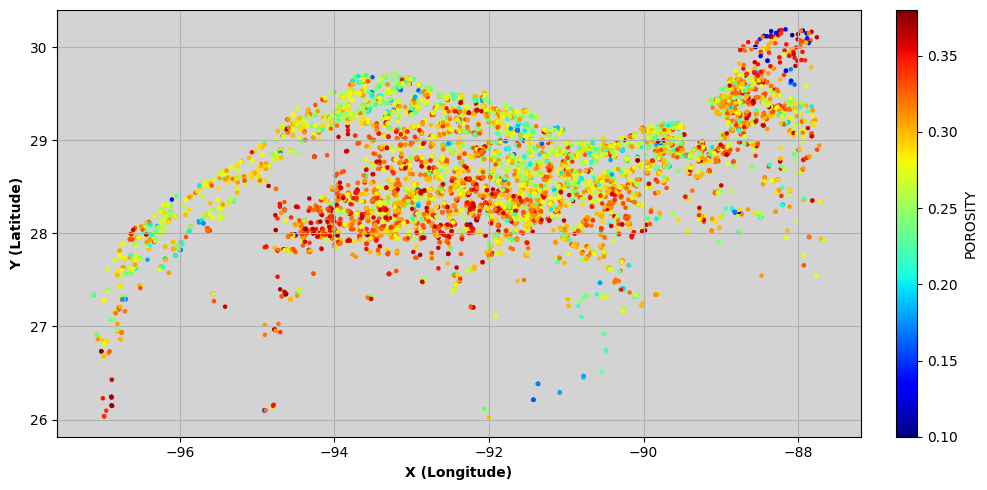

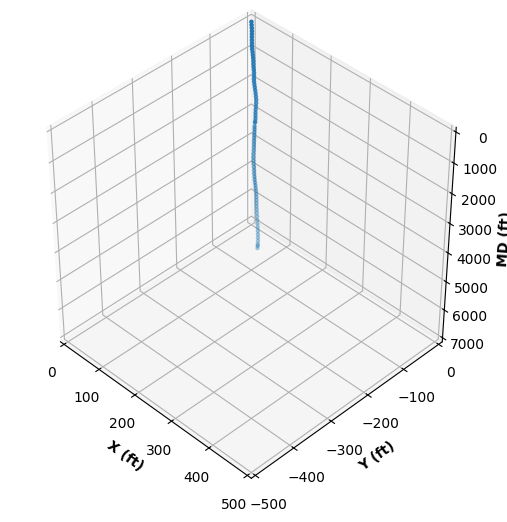

In [3]:
spl.plot_ccs_sand_wells()

survey = pd.read_csv('Data/UT dir surveys/427064023000_DIRSUR_NAD27(USFEET)US-SPC27-EXACT(TX-27SC).TXT',skiprows=3, sep='\s+')
spl.plot_survey(survey)

dict_keys(['DEPT', 'ASN', 'CALI', 'DRHO', 'DT', 'GR', 'GR_NORM', 'ILD', 'RHOB', 'SP', 'SP_NORM', 'VSH_GR', 'VSH_SP'])


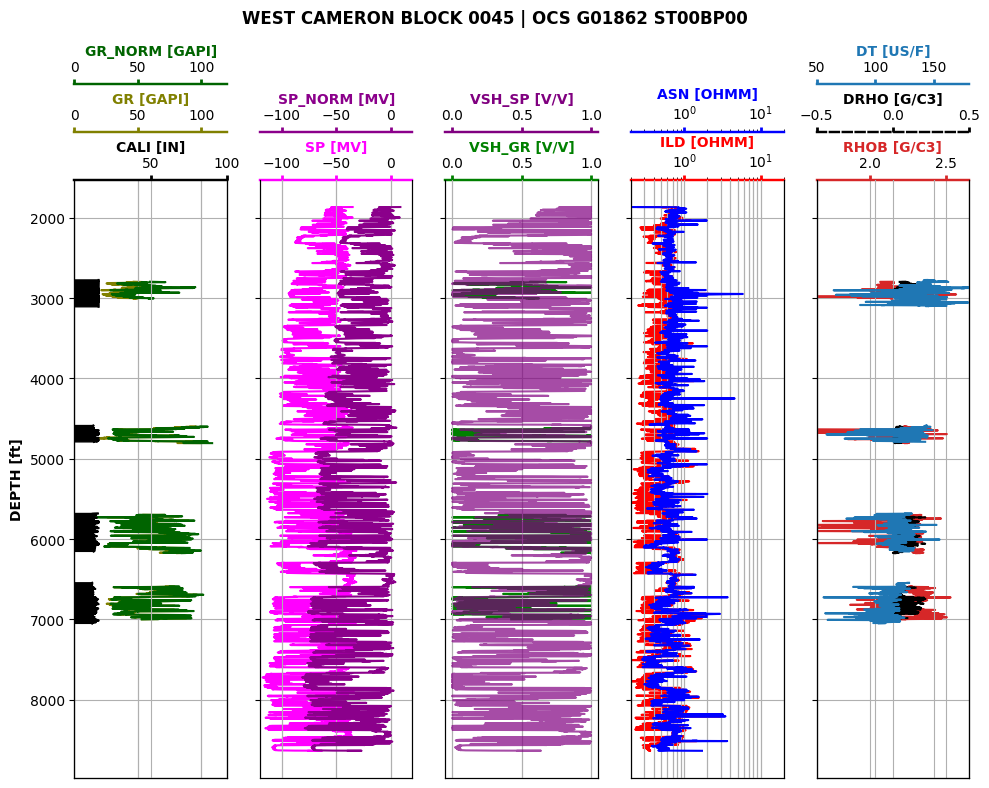

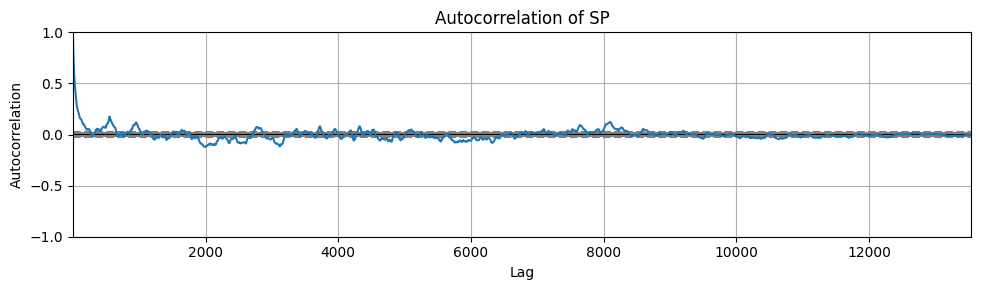

In [4]:
well_name = '17700004060000'
well_log = lasio.read('Data/UT Export 9-19/{}.las'.format(well_name))
spl.plot_well(well_name)

In [5]:
spl.make_arima(well_log)

***
# SP BASELINE CORRECTION
***

In [ ]:
### PRELOAD
logs = np.load('Data/log_data.npy')
print(logs.shape)

In [ ]:
logs_list = {}
files = os.listdir('Data/UT Export 9-19/')
k = 0
for file in tqdm(files, desc='Processing Files', unit='file'):
    log = lasio.read('Data/UT Export 9-19/{}'.format(file))
    if 'SP' in log.curvesdict.keys() and 'SP_NORM' in log.curvesdict.keys():
        logs_list[k] = pd.DataFrame({'DEPT': log['DEPT'], 'SP': log['SP'], 'SP_NORM': log['SP_NORM']})
        k += 1

logs = np.zeros((len(logs_list),44055,3))
for i in range(len(logs_list)):
    logs[i,logs_list[i].index,:] = logs_list[i].values
logs = np.where(logs==0, np.nan, logs)

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(20, 12), sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        axs[i,j].plot(logs[k,:,1], logs[k,:,0], c='tab:purple', label='SP')
        axs[i,j].plot(logs[k,:,2], logs[k,:,0], c='darkmagenta', label='SP_NORM')
        axs[i,j].set_title(os.listdir('Data/UT Export 9-19/')[k].split('.')[0], weight='bold')
        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        k += 1
#axs[-1,-1].legend(facecolor='wheat', edgecolor='k')
axs[0,0].invert_yaxis()
plt.tight_layout(); plt.show()

In [ ]:
logs_clean = np.nan_to_num(logs, nan=0)
print(logs_clean.shape)

X_data = np.expand_dims(logs_clean[:,:,:2],-1)
y_data = np.expand_dims(np.expand_dims(logs_clean[:,:,-1],-1),-1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.227)

print('X_train: {} | y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test:  {}  | y_test:  {}'.format(X_test.shape, y_test.shape))

In [ ]:
fig, axs = plt.subplots(3, 10, figsize=(20, 12), sharey=True)
k = 0
for i in range(3):
    for j in range(10):
        axs[i,j].plot(logs_clean[k,:,1], logs_clean[k,:,0], c='tab:purple', label='SP')
        axs[i,j].plot(logs_clean[k,:,2], logs_clean[k,:,0], c='darkmagenta', label='SP_NORM')
        axs[i,j].set_title(os.listdir('Data/UT Export 9-19/')[k].split('.')[0], weight='bold')
        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        k += 1
#axs[-1,-1].legend(facecolor='wheat', edgecolor='k')
axs[0,0].invert_yaxis()
plt.tight_layout(); plt.show()

In [ ]:
def make_nn():
    K.clear_session()
    def enc_layer(inp, units):
        _ = Conv1D(units, 15, padding='same')(inp)
        _ = BatchNormalization()(_)
        _ = ReLU()(_)
        _ = MaxPooling1D(2)(_)
        return _
    
    def dec_layer(inp, units):
        _ = Conv1D(units, 15, padding='same')(inp)
        _ = BatchNormalization()(_)
        _ = ReLU()(_)
        _ = UpSampling1D(2)(_)
        return _
    
    inputs = Input(shape=(44055,2))

    x1 = enc_layer(inputs, 16)
    x2 = enc_layer(x1, 64)
    x3 = enc_layer(x2, 128)

    y3 = dec_layer(x3, 64)
    y2 = dec_layer(y3, 16)
    y1 = dec_layer(y2, 4)

    _ = ZeroPadding1D((4,3))(y1)
    _ = Conv1D(1, 15, padding='same')(_)

    return Model(inputs, _)

model = make_nn()
model.summary()

In [ ]:
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
fit = model.fit(X_train, y_train, 
                epochs           = 100,
                batch_size       = 30,
                validation_split = 0.25,
                shuffle          = True,
                verbose          = 0)

In [ ]:
y_train_pred = model.predict(X_train).squeeze().astype('float32')
y_test_pred  = model.predict(X_test).squeeze().astype('float32')
print('y_train_pred: {} | y_test_pred: {}'.format(y_train_pred.shape, y_test_pred.shape))

train_mse = mean_squared_error(y_train.squeeze().astype('float32'), y_train_pred)
test_mse  = mean_squared_error(y_test.squeeze().astype('float32'), y_test_pred)
print('Train MSE: {:.4f} | Test MSE: {:.4f}'.format(train_mse, test_mse))

In [ ]:
X_train, X_test, y_train, y_test = X_train.squeeze(), X_test.squeeze(), y_train.squeeze(), y_test.squeeze()
print('X_train: {} | y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test:  {}  | y_test:  {}'.format(X_test.shape, y_test.shape))

In [ ]:
nrows, ncols = 3, 8
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 12))
k, mult = 0, 5
for i in range(nrows):
    for j in range(ncols):

        mask = ~np.isnan(X_train[k,:,0])
        index = X_train[k,:,0][mask]
        x  = X_train[k,:,1][mask]
        y  = y_train[k][mask]
        yh = y_train_pred[k][mask]

        axs[i,j].plot(x, index, c='tab:purple', label='SP')
        axs[i,j].plot(y, index, c='darkmagenta', label='True Corr.')
        axs[i,j].plot(yh, index, c='k', label='Pred Corr.')

        axs[i,0].set_ylabel('DEPTH [ft]', weight='bold')
        axs[-1,j].set_xlabel('SP [mV]', weight='bold')
        axs[i,j].set_xlim(-200, 50)
        axs[i,j].grid(True, which='both')
        axs[i,j].invert_yaxis()
        k += 1*mult

plt.tight_layout(); plt.show()

***
# END